In [2]:
import numpy as np


import time
import numba



## Coulomb Interaction on Excited States
Consider two molecules, each with excitation energies $E_1$ and $E_2$ and transition densities $\rho_{eg}(\mathbf{r}_1)$ and $\rho_{eg}(\mathbf{r}_2)$.  
<img src="images/monomers.png" width="400" />  
When combined, the supramolecular system have will have new excited states with a splitting $\Delta$  
<img src="images/splitting.png" alt="Drawing" style="width: 500px;"/>  
This splitting depends on their Coulomb coupling,  
<img src="images/eq_coulomb.png" alt="Drawing" style="width: 300px;"/>  
This can be approximated by dividing the density into a grid and summing over each density "cubes"  
<img src="images/eq_coulomb_approx.png" alt="Drawing" style="width: 150px;"/>
<img src="images/cube_sum.png" alt="Drawing" style="width: 400px;"/>
The following code examples will demonstrate various implementations of this summation  

## Importing the Cube Data
First we load in two transition density cube files for a cresyl-violet dimer. 
- Their geometries were oriented in a stacked configuration and optimized at the CAM-B3LYP/6-31G* level of theory with Gaussian 16.  
- MultiWfn was used to generate the cube densities from a Gaussian formatted checkpoint file.  

Because some of these examples will take some time to run, we will use two versions of the data; one with the "regular" number of cube points and another with a reduced number of points.

Since the for loops scale by $\mathcal{O}(NM)$ with $N$ and $M$ being the number of points in the first and second cube densities, we can approximate the time it takes to run the regular sized dataset by multiplying by the ratio of the two dataset sizes.

In [1]:
import Cube # custom gaussian cube file reader
from os.path import *

data_1 = Cube.CubeData(join('CV_data', 'transdens_1_low.cub'))
data_2 = Cube.CubeData(join('CV_data', 'transdens_2_low.cub'))
dV_12 = data_1.dV * data_2.dV
data_1_L = Cube.CubeData(join('CV_data', 'transdens_1_extra_low.cub'))
data_2_L = Cube.CubeData(join('CV_data', 'transdens_2_extra_low.cub'))
dV_12_L = data_1_L.dV * data_2_L.dV

print("Number of points in regular cubes: ", data_1.coords.shape, data_2.coords.shape)
print("                                   ", data_1.cube_data.shape, data_2.cube_data.shape)

print("Number of points in reduced cubes: ", data_1_L.coords.shape, data_2_L.coords.shape)
print("                                   ", data_1_L.cube_data.shape, data_2_L.cube_data.shape)

point_ratio = data_1.n_points * data_2.n_points/(data_1_L.n_points * data_2_L.n_points)
print("Point ratio: ", point_ratio)

#   will store all of our benchmarks
global_timers = {}

Reading cube file
Formatting
Done
Reading cube file
Formatting
Done
Reading cube file
Formatting
Done
Reading cube file
Formatting
Done
Number of points in regular cubes:  (61617, 3) (66654, 3)
                                    (61617,) (66654,)
Number of points in reduced cubes:  (2975, 3) (5220, 3)
                                    (2975,) (5220,)
Point ratio:  264.46566328600403


### A First Attempt: Pure Python

The doouble summation is implimented below in what would be considered the most straight forward way posssible:
- Construct two for loops, one inner and one outer, for each cube densities.
- Sum over the product of each cube divided by the distance between them

In [18]:
from math import sqrt
import time
AU_2_EV = 27.211396 # convert from atomic units to electron volts

def calc_coulomb_pure_python(pts_1, rho_1, pts_2, rho_2, dV):
    from math import sqrt   #   normally, this is imported beforehand, but we need to fix fomr Jupyter multiprocessing bugs (discussed later)
    total = 0.0
    count = 0
    n_pts_1 = len(pts_1)
    n_pts_2 = len(pts_2)
    n_pts_12 = n_pts_1*n_pts_2
    print_num = n_pts_12//5
    for i in range(n_pts_1):
        for j in range(n_pts_2):
            if count % print_num == 0:
                print(f"    Coulomb Integral {(count / n_pts_12*100):.1f} %")

            x1, y1, z1 = pts_1[i]
            x2, y2, z2 = pts_2[j]
            dx = x1 - x2
            dy = y1 - y2
            dz = z1 - z2
            r = sqrt(dx**2 + dy**2 + dz**2)
            total += rho_1[i]*rho_2[j]/r
            count += 1
    return total*dV

#   Record the current time, run the code, and record the current time again.
#   The difference in the two times measures the execution time.
start = time.time()
total = calc_coulomb_pure_python(data_1_L.coords, data_1_L.cube_data, data_2_L.coords, data_2_L.cube_data, dV_12_L)
total_time = (time.time() - start)*point_ratio
global_timers['pure_python'] = total_time
print(f'pure_python: {total_time:.2f} s ({total*AU_2_EV} eV)')

    Coulomb Integral 0.0 %
    Coulomb Integral 20.0 %
    Coulomb Integral 40.0 %
    Coulomb Integral 60.0 %
    Coulomb Integral 80.0 %
pure_python: 5599.56 s (0.23374090007118797 eV)


### Numpy

Numpy gives us a way to manipulate multiple data points, stored in arrays, at the same time.
- Think of numpy arrays as mathematical vectors and matrices.

In [4]:
import numpy as np

a = np.array([1, 2, 3, 4, 5])
b = np.array([2, 3, 4, 5, 6])
c = np.array([[1, 2], [3, 4]])
d = np.array([[2, 0], [0, 3]])

print(f"{ a + 2 = }")
print(f"{ np.sum(a) = }")
print(f"{ a * b = }")
print(f"{ c @ d = }")

 a + 2 = array([3, 4, 5, 6, 7])
 np.sum(a) = 15
 a * b = array([ 2,  6, 12, 20, 30])
 c @ d = array([[ 2,  6],
       [ 6, 12]])


When you run a line of python, you are actually running a bunch of compiled C++ code in the background  
<img src="images/python_cpp.png" width="600" />  
source: https://pythonextensionpatterns.readthedocs.io/en/latest/refcount.html  
Each line must go through the Python interpreter to execute the correct `PyObject` and it's respective code.  

Numpy functions are also implemented as compiled C-code, but each iteration within a function (np.sum, np.exp, etc.) is all done internally. This means the interpreter is only needed once for each numpy call!

The next implementation replaces the inner loop with pure Numpy functions. Note the huge speed up!

In [13]:
def calc_coulomb_numpy(pts_1, rho_1, pts_2, rho_2, dV):
    total = 0.0
    n_pts_1 = len(pts_1)
    print_num = n_pts_1//5
    for i in range(n_pts_1):
        if i % print_num == 0:
            print(f"    Coulomb Integral {(i / n_pts_1*100):.1f} %")

        dr = pts_1[i] - pts_2
        r = np.linalg.norm(dr, axis=1)
        total += rho_1[i]*np.sum(rho_2/r)

    return total*dV

start = time.time()
total = calc_coulomb_numpy(data_1_L.coords, data_1_L.cube_data, data_2_L.coords, data_2_L.cube_data, dV_12_L)
total_time = (time.time() - start)*point_ratio

#   depending on the estimated time with the reduced dataset, you may be able to uncomment 
#   out the next two lines and use the entire dataset if you are willing to wait.
# total = calc_coulomb_numpy(data_1.coords, data_1.cube_data, data_2.coords, data_2.cube_data, dV_12)
# total_time = (time.time() - start)

global_timers['numpy'] = total_time
print(f'numpy: {total_time:.2f} s ({total*AU_2_EV} a.u.)')

    Coulomb Integral 0.0 %
1.8947718943147686e-14
1.5708055125357645e-13
5.548581689376305e-13
1.0066774701478967e-12
1.2087526174447657e-12
1.2442687912095858e-12
1.2467167688420347e-12
1.9678626211267078e-12
7.664676063714275e-12
2.5384523834981576e-11
4.7045816328833526e-11
5.7430252477503714e-11
5.9378109069767e-11
5.952072391499704e-11
8.369880155761644e-11
2.776819958937298e-10
8.897040935688052e-10
1.6479105997858859e-09
2.016079264864964e-09
2.0859983095841115e-09
2.0911777294556968e-09
2.4325874512376626e-09
5.177869791400447e-09
1.3867349743043303e-08
2.4674066962499606e-08
2.994547843407292e-08
3.095310395141481e-08
3.102833570028983e-08
3.290213488837725e-08
4.798469797784619e-08
9.605068140922377e-08
1.560566865463285e-07
1.852606192941368e-07
1.908697201149894e-07
1.9129268025607534e-07
1.9528249163837254e-07
2.2738229612992104e-07
3.3076978413839015e-07
4.603072284304099e-07
5.227563146170502e-07
5.348035406350126e-07
5.357256667836479e-07
5.390248687926121e-07
5.6528121

### Multithreading

Modern CPUs contain multiple CPU cores, each acting as an individual CPU, but all connected to the same internal memory (either CPU cache or RAM). Each core can perform (roughly) the same amount of work as another core. Unless your code is told to do so, python will run on only one core at a time.

<img src="images/cpu.png" alt="Drawing" style="width: 400px;"/>

We tell python how to use these cores by setting up software "threads". Each thread is branch off of the main python program that does a separate amount of work and is assigned to one per CPU core each.
- Technically, the number of threads are not limited by the number of cores, but with HPC, it's not beneficial to assign more. With some software, this can actually hurt your performance!  

<img src="images/threading.png" alt="Drawing" style="width: 700px;"/>

#### Implementation

We can split up our integral work by partitioning the outer loop (over molecule 1) into separate contributions of the total density. 
- Each sub-density will be assigned to a separate thread and will only affect the number of iterations in the outer for-loop.  
- The inner for-loop will remain the same.  

<img src="images/density_split.png" alt="Drawing" style="width: 400px;"/>

In [19]:
import threading

#   Shared memory that each thread has access to
thread_totals = np.array([])

def _coulomb_by_indix(indicies, pts_1, rho_1, pts_2, rho_2, dV, thread_ID):

    total = 0.0
    count = 0
    n_pts_1 = len(indicies)
    n_pts_2 = len(pts_2)
    n_pts_12 = n_pts_1*n_pts_2
    print_num = n_pts_12//5
    for i in indicies: # Now we loop over specified indicies only
        for j in range(n_pts_2):
            if count % print_num == 0:
                #   Also print thread ID with the progress
                print(f"    Coulomb Integral {thread_ID} {(count / n_pts_12*100):.1f} %")

            x1, y1, z1 = pts_1[i]
            x2, y2, z2 = pts_2[j]
            dx = x1 - x2
            dy = y1 - y2
            dz = z1 - z2
            r = sqrt(dx**2 + dy**2 + dz**2)
            total += rho_1[i]*rho_2[j]/r
            count += 1

    #   update the global integral totals
    thread_totals[thread_ID] = total*dV

def calc_coulomb_thread(n_threads, pts_1, rho_1, pts_2, rho_2, dV):
    global thread_totals
    all_threads = []
    #   initialize each thread's total to zero
    thread_totals = np.zeros(n_threads)
    for n in range(n_threads):
        #   these will be the indicies used by the inner Coulomb loop
        indicies = np.arange(n, len(pts_1), n_threads)
        print(f"Thread {n} using indicies ", *indicies[0:4], "...")
        
        thread = threading.Thread(
            target=_coulomb_by_indix, 
            args=(indicies, pts_1, rho_1, pts_2, rho_2, dV, n)
            )
        all_threads.append(thread)

        #   the function is not called until we start the thread
        thread.start()

    #   now wait for all the threads to complete
    for thread in all_threads:
        thread.join()

    #   The total Coulomb integral is equal to the sum of each thread's partial integral
    return np.sum(thread_totals)

start = time.time()
total = calc_coulomb_thread(4, data_1_L.coords, data_1_L.cube_data, data_2_L.coords, data_2_L.cube_data, dV_12_L)
# total = calc_coulomb_thread(4, data_1.coords, data_1.cube_data, data_2.coords, data_2.cube_data, dV_12)
total_time = (time.time() - start)*point_ratio
global_timers['pure_python_threaded'] = total_time
print(f'pure_python_threaded: {total_time:.2f} s ({total*AU_2_EV} a.u.)')
print(f'pure_python:          {global_timers["pure_python"]:.2f} s ')

Thread 0 using indicies  0 4 8 12 ...
    Coulomb Integral 0 0.0 %
Thread 1 using indicies  1 5 9 13 ...
    Coulomb Integral 1 0.0 %
Thread 2 using indicies  2 6 10 14 ...
    Coulomb Integral 2 0.0 %
Thread 3 using indicies  3 7 11 15 ...
    Coulomb Integral 3 0.0 %
    Coulomb Integral 0 20.0 %
    Coulomb Integral 1 20.0 %
    Coulomb Integral 2 20.0 %
    Coulomb Integral 3 20.0 %
    Coulomb Integral 2 40.0 %    Coulomb Integral 0 40.0 %

    Coulomb Integral 1 40.0 %
    Coulomb Integral 3 40.0 %
    Coulomb Integral 1 60.0 %
    Coulomb Integral 2 60.0 %
    Coulomb Integral 0 60.0 %
    Coulomb Integral 3 60.0 %
    Coulomb Integral 2 80.0 %
    Coulomb Integral 1 80.0 %
    Coulomb Integral 0 80.0 %
    Coulomb Integral 3 80.0 %
pure_python_threaded: 5591.30 s (0.23374090007119025 a.u.)
pure_python: 5599.56 s 


### Global Interpreter Lock

You should have noticed that the above code didn't run any faster than the original pure-python function defined above. This is because every line in the function must obtain the Global Interpreter Lock (GIL) before it can be executed. 

In [10]:
#   obtain GIL
a = 5
#   release GIL
#   obtain GIL
print(a)
#   release GIL

5


Instead, we can replace the inner for-loop using Numpy routines, which release the GIL once executed. This allows another python line to be run while Numpy is handling the numerical heavy lifting.

In [20]:
import threading

thread_totals = np.array([])

def _coulomb_by_indix_2(indicies, pts_1, rho_1, pts_2, rho_2, dV, thread_ID):
    total = 0.0
    n_pts_1 = len(indicies)
    print_num = n_pts_1//5
    for count, i in enumerate(indicies): # EDIT: loop over specified indicies only
        if count % print_num == 0:
            print(f"    Coulomb Integral {thread_ID} {(count / n_pts_1*100):.1f} %")

        dr = pts_2 - pts_1[i]
        r = np.linalg.norm(dr, axis=1)
        total += rho_1[i]*np.sum(rho_2/r)

    thread_totals[thread_ID] = total*dV

def calc_coulomb_thread(n_threads, pts_1, rho_1, pts_2, rho_2, dV):
    global thread_totals
    all_threads = []
    thread_totals = np.zeros(n_threads)
    for n in range(n_threads):
        #   these will be the indicies used by the inner Coulomb loop
        indicies = np.arange(n, len(pts_1), n_threads)
        print(f"Thread {n} using indicies ", *indicies[0:4], "...")
        
        thread = threading.Thread(
            target=_coulomb_by_indix_2, 
            args=(indicies, pts_1, rho_1, pts_2, rho_2, dV, n)
            )
        all_threads.append(thread)

        #   the function is not called until we start the thread
        thread.start()

    #   now wait for all the threads to complete
    for thread in all_threads:
        thread.join()

    #   The total Coulomb integral is equal to the sum of each thread's partial integral
    return np.sum(thread_totals)

start = time.time()
# total = calc_coulomb_thread(4, data_1_L.coords, data_1_L.cube_data, data_2_L.coords, data_2_L.cube_data, dV_12_L)
total = calc_coulomb_thread(4, data_1.coords, data_1.cube_data, data_2.coords, data_2.cube_data, dV_12)
total_time = (time.time() - start)
global_timers['numpy_threaded'] = total_time
print(f'numpy_threaded: {total_time:.2f} s ({total*AU_2_EV} a.u.)')
print(f'numpy:          {global_timers["numpy"]:.2f} s ')

Thread 0 using indicies  0 4 8 12 ...
    Coulomb Integral 0 0.0 %
Thread 1 using indicies  1 5 9 13 ...
    Coulomb Integral 1 0.0 %
Thread 2 using indicies  2 6 10 14 ...
    Coulomb Integral 2 0.0 %
Thread 3 using indicies  3 7 11 15 ...
    Coulomb Integral 3 0.0 %
    Coulomb Integral 3 20.0 %
    Coulomb Integral 2 20.0 %
    Coulomb Integral 0 20.0 %
    Coulomb Integral 1 20.0 %
    Coulomb Integral 3 40.0 %
    Coulomb Integral 1 40.0 %
    Coulomb Integral 0 40.0 %
    Coulomb Integral 2 40.0 %


In [42]:
thread_totals

array([-1.98903295e-21, -2.11631717e-21, -2.21692748e-21, -2.22776779e-21])

In [7]:
@numba.jit(nopython=True)
def calc_coulomb_numba(pts_1, rho_1, pts_2, rho_2, dV):
    total = 0.0
    n_pts_1 = len(pts_1)
    n_pts_2 = len(pts_2)
    for i in numba.prange(n_pts_1):
        for j in range(n_pts_2):

            x1, y1, z1 = pts_1[i]
            x2, y2, z2 = pts_2[j]
            dx = x1 - x2
            dy = y1 - y2
            dz = z1 - z2
            r = sqrt(dx**2 + dy**2 + dz**2)
            total += rho_1[i]*rho_2[j]/r
            
    return total*dV

start = time.time()
total = calc_coulomb_numba(data_1.coords, data_1.cube_data, data_2.coords, data_2.cube_data, dV_12)
total_time = (time.time() - start)
global_timers['numba'] = (total, total_time)
print(f'numba: {total_time:.2f} s ({total*AU_2_EV} a.u.)')

numba: 14.96 s (0.2422872334903655 a.u.)


In [9]:
@numba.jit(nopython=True, parallel=True)
def calc_coulomb_numba_parallel(pts_1, rho_1, pts_2, rho_2, dV):
    total = 0.0
    n_pts_1 = len(pts_1)
    n_pts_2 = len(pts_2)
    for i in numba.prange(n_pts_1):
        for j in range(n_pts_2):

            x1, y1, z1 = pts_1[i]
            x2, y2, z2 = pts_2[j]
            dx = x1 - x2
            dy = y1 - y2
            dz = z1 - z2
            r = sqrt(dx**2 + dy**2 + dz**2)
            total += rho_1[i]*rho_2[j]/r
            
    return total*dV

start = time.time()
numba.set_num_threads(4)
total = calc_coulomb_numba_parallel(data_1.coords, data_1.cube_data, data_2.coords, data_2.cube_data, dV_12)
total_time = (time.time() - start)
global_timers['numba_parallel'] = (total, total_time)
print(f'numba_parallel: {total_time:.2f} s ({total*AU_2_EV} a.u.)')

numba_parallel: 4.55 s (0.24228723350222542 a.u.)


In [12]:
@numba.jit(parallel=True, nopython=True)
def calc_coulomb_numba_parallel_numpy(pts_1, rho_1, pts_2, rho_2, dV):

    n_pts_1 = len(pts_1)
    total = 0.0
    count = 0.0
    n_threads = numba.get_num_threads()
    for i in numba.prange(n_pts_1):

        dr = pts_2 - pts_1[i]
        dr2 = dr*dr
        r = np.sqrt(dr2[:, 0] + dr2[:, 1] + dr2[:, 2])
        total += rho_1[i]*np.sum(rho_2/r)
        count += 1

    return total*dV

start = time.time()
numba.set_num_threads(4)
total = calc_coulomb_numba_parallel_numpy(data_1.coords, data_1.cube_data, data_2.coords, data_2.cube_data, dV_12)
total_time = (time.time() - start)
global_timers['numba_parallel_numpy'] = (total, total_time)
print(f'numba_parallel_numpy: {total_time:.2f} s ({total*AU_2_EV} a.u.)')

numba_parallel_numpy: 10.03 s (0.2422872335002303 a.u.)


In [11]:
@numba.jit(nopython=True)
def calc_coulomb_numba_numpy(pts_1, rho_1, pts_2, rho_2, dV):
    n_pts_1 = len(pts_1)
    total = 0.0
    for i in numba.prange(n_pts_1):
        dr = pts_2 - pts_1[i]
        dr2 = dr*dr
        r = np.sqrt(dr2[:, 0] + dr2[:, 1] + dr2[:, 2])
        total += rho_1[i]*np.sum(rho_2/r)

    return total*dV

start = time.time()
total = calc_coulomb_numba_numpy(data_1.coords, data_1.cube_data, data_2.coords, data_2.cube_data, dV_12)
total_time = (time.time() - start)
global_timers['numba_numpy'] = (total, total_time)
print(f'numba_numpy: {total_time:.2f} s ({total*AU_2_EV} a.u.)')

KeyboardInterrupt: 

In [9]:
import multiprocess as mp # use with Jupyter Notebooks
#import multiprocess as mp # use with traditional python files

def calc_coulomb_MP(n_proc, pts_1, rho_1, pts_2, rho_2, dV):
    #   outer loop will be split by each process
    pts_1_split = np.array_split(pts_1, n_proc)
    rho_1_split = np.array_split(rho_1, n_proc)

    #   inner loop will remain the same, so we simply copy the data
    pts_2_copies = [pts_2]*n_proc
    rho_2_copies = [rho_2]*n_proc

    #   a copy also needs to be supplied to each process
    dV_list = [dV]*n_proc

    with mp.Pool(n_proc) as pool:
        func_params = zip(pts_1_split, rho_1_split, pts_2_copies, rho_2_copies, dV_list)
        results = pool.starmap(calc_coulomb_pure_python, func_params)

    return np.sum(results)

# calc_coulomb_pure_python(data_1_L.coords, data_1_L.cube_data, data_2_L.coords, data_2_L.cube_data, dV_12_L)

start = time.time()
total = calc_coulomb_MP(4, data_1_L.coords, data_1_L.cube_data, data_2_L.coords, data_2_L.cube_data, dV_12_L)
total_time = (time.time() - start)*point_ratio
global_timers['multiprocessing'] = (total, total_time)
print(f'multiprocessing: {total_time:.2f} s ({total*AU_2_EV} a.u.)')

multiprocessing: 4139.28 s (0.23374090007120177 a.u.)


In [85]:
a = np.arange(10)
np.array_split(a, 3)

[array([0, 1, 2, 3]), array([4, 5, 6]), array([7, 8, 9])]

In [93]:
def calc_coulomb_MP_numba(n_proc, pts_1, rho_1, pts_2, rho_2, dV):
    #   outer loop will be split by each process
    pts_1_split = np.array_split(pts_1, n_proc)
    rho_1_split = np.array_split(rho_1, n_proc)

    #   inner loop will remain the same, so we simply copy the data
    pts_2_copies = [pts_2]*n_proc
    rho_2_copies = [rho_2]*n_proc

    #   a copy also needs to be supplied to each process
    dV_list = [dV]*n_proc

    with mp.Pool(n_proc) as pool:
        func_params = zip(pts_1_split, rho_1_split, pts_2_copies, rho_2_copies, dV_list)
        results = pool.starmap(calc_coulomb_numba, func_params)

    return np.sum(results)

n_keep = 1
start = time.time()
total = calc_coulomb_MP_numba(4, data_1_L.coords, data_1_L.cube_data, data_2_L.coords, data_2_L.cube_data, dV_12_L)
total_time = (time.time() - start)*point_ratio
global_timers['multiprocessing_numba'] = (total, total_time)
print(f'multiprocessing_numba: {total_time:.2f} s ({total} a.u.)')

multiprocessing_numba: 68.91 s (0.008589816563295825 a.u.)


In [15]:
for name, val in global_timers.items():
    print(f'{name:25s} {val[1]:10.1f}')

pure_python                  14535.4
numpy_L                         78.5
numba                           15.0
numba_parallel                   4.5
numba_parallel_numpy            10.0
threaded                        46.5


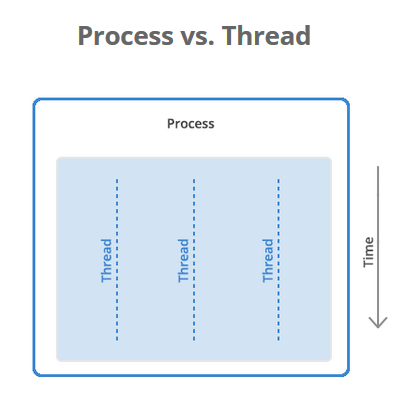

In [ ]:
# def calc_coulomb_pure_python(xyz_1: np.ndarray, dens_1: np.ndarray, xyz_2: np.ndarray, dens_2: np.ndarray):
def calc_coulomb_pure_numpy_mix(pts_1, rho_1, pts_2, rho_2, dV):
    print("Pure Python Coulomb Integral")

    total = 0.0
    count = 0
    n_pts_1 = len(pts_1)
    n_pts_2 = len(pts_2)
    n_pts_12 = n_pts_1*n_pts_2
    print_num = n_pts_12//5
    for i in range(n_pts_1):
        for j in range(n_pts_2):
            if count % print_num == 0:
                print(f"    Coulomb Integral {(count / n_pts_12*100):.1f} %")

            dr = pts_1[i] - pts_2[j]
            r = np.linalg.norm(dr)
            total += rho_1[i]*rho_2[j]/r
            count += 1

    return total*dV

start = time.time()
total = calc_coulomb_pure_numpy_mix(data_1_L.coords, data_1_L.cube_data, data_2_L.coords, data_2_L.cube_data, dV_12_L)
total_time = (time.time() - start)*point_ratio
global_timers['pure_numpy_mix'] = (total, total_time)
print(f'pure_numpy_mix: {total_time:.2f} s ({total*AU_2_EV} a.u.)')

Pure Python Coulomb Integral
    Coulomb Integral 0.0 %


KeyboardInterrupt: 